In [15]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.special as spsp
import scipy.stats as spst

from statsmodels.api import Logit
from statsmodels.formula.api import poisson, negativebinomial, ols, logit
from statsmodels.base.model import GenericLikelihoodModel

import warnings
warnings.filterwarnings('ignore')

# Setting

Suppose we are polling three new product variations with customers who browse our shopping website. Each customer surveyed indicates whether they like or dislike each variation. The collected data is shown below with the following columns:

* **time**: Amount of time spent browsing the website
* **purchases**: The number of purchases that they have made
* **product1/2/3**: The customer's rating of each product (1 for like, 0 for dislike)

In [16]:
Products = pd.read_csv('Data.csv')
Products  

,intercept,time,purchases,product1,product2,product3
0,1,0.228273,1,0,0,0
1,1,1.026890,4,0,1,1
2,1,0.839585,6,1,1,1
3,1,0.591182,4,0,1,1
4,1,0.956888,2,0,1,0
...,...,...,...,...,...,...
495,1,0.253807,2,0,1,0
496,1,0.924209,2,0,1,0
497,1,0.597519,3,0,1,0
498,1,0.414284,1,0,0,0


# Part 1 [8 pts]

Let's use this data to simulate a policy of pure exploration. Every customer is randomly shown one of the three products. The reward $Reward_i$ is their 1/0 rating for that product, and the regret will be defined as 

$$Regret_i = \max(product1_i,product2_i,product3_i) - Reward_i.$$

Randomly sample $N=500$ customers (with replacement) and a product for each, and store the resultant regret. Perform $M=50$ simulations and plot the average cumulative regret over $N$.

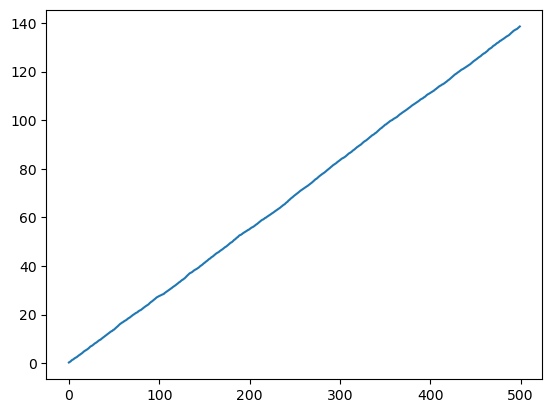

In [17]:
from statsmodels.tools.tools import add_constant
M = 50
N = 500
avg_regret = np.zeros(N)

for m in range(M):
    sample = Products.sample(n = N, replace = True)
    regret = []
    for n in range(N):
        customer = np.random.choice(['product1', 'product2', 'product3'])
        reward = sample.iloc[n][customer]
        max_here = sample.iloc[n][['product1', 'product2', 'product3']].max()
        regret_i = max_here - reward
        regret.append(regret_i)
    avg_regret += regret
avg_regret /= M

plt.plot(np.cumsum(avg_regret))
plt.show()

# Part 2 [10 pts]

Now we will run a bandit simulation using this data, where each product is an individual "arm". When customer $i$ is shown a product, $Reward_i$ is their 1/0 rating for that product, and the regret will be defined as 

$$Regret_i = \max(product1_i,product2_i,product3_i) - Reward_i.$$

We will first run a LinUCB bandit estimator, which will assume that the reward for each arm is determined by a linear model of **time** and **purchases**:

$$Reward_{ik} = \beta_{0k} + \beta_{1k} time_i + \beta_{2k} purchases_i + \epsilon_{ik}$$

Implement `linucb()` using the demonstration from lecture as a starting point. Store the regret at each trial and it when finished. Using $\alpha=1$, run the bandit for $N=500$ trials and $M=50$ simulations. Generate a plot showing the average cumulative regret per trial.

In [18]:
def linucb(alpha, trials):
    K = 3 # 3 arms
    D = 2 # 2 features
    A = [np.eye(D+1) for i in range(K)]
    b = [np.zeros(D+1) for i in range(K)]
    regret = np.zeros(trials)

    for n in range(trials):

        sample = Products.sample(n = 1, replace=True).iloc[0]
        x = np.array([1, sample['time'], sample['purchases']])
        UCB = []
        for i in range(K): 
            Ainv = np.linalg.inv(A[i])
            Rhat = x @ Ainv @ b[i]
            Uhat = alpha * np.sqrt(x.T @ Ainv @ x)
            UCB.append(Rhat + Uhat)
        UCB = np.array(UCB)

        idx = np.argmax(UCB)
        r = sample[f'product{idx+1}']

        A[idx] += np.outer(x, x)
        b[idx] += r * x
        all_rewards = [sample[f'product{i+1}'] for i in range(K)]
        regret[n] = np.max(all_rewards) - all_rewards[idx]
    
    return regret

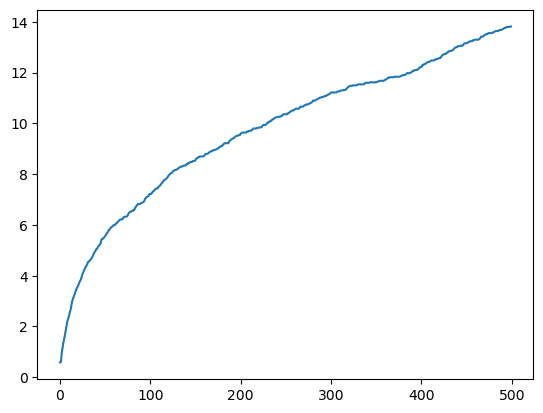

In [19]:
alpha = 1
N = 500
M = 50
avg_regret = np.zeros(N)

for m in range(M):
    regret = linucb(alpha, N)
    avg_regret += regret 
avg_regret /= M

plt.plot(np.cumsum(avg_regret))
plt.show()

# Part 3 [14 pts]

Now let's suppose that each reward follows a logit model: 

$$P(Reward_{ik}=1) = \frac{\exp(\beta_{0k}+\beta_{1k}time_i +\beta_{2k}purchases_i)}{1+\exp(\beta_{0k}+\beta_{1k}time_i +\beta_{2k}purchases_i)}$$

To run a bandit algorithm using this reward model, we will need to use GLM-UCB. Implement `glmucb()` using the demonstration from lecture as a starting point. Store the regret at each trial and it when finished. Using $\alpha=1$, run the bandit for $N=500$ trials and $M=50$ simulations. Generate a plot showing the average cumulative regret per trial.

To keep things simple, you may exclude the trials used for initializing GLM-UCB from the $N=500$, and also exclude them from the cumulative regret.

In [22]:
def glmucb(alpha, trials):
    K = 3
    D = 2
    regret = np.zeros(trials)

    beta = [np.ones(D+1) for i in range(K)]
    X = []
    y = []
    # Originally placed these two line below right here, checked with TA and moved it to inside the loop, the plot geneerated is pretty similar in overall shape except at the begining, the range changed a bit.
    #sample = Products.sample(n = 1, replace=True).iloc[0]
    #x = np.array([1, sample['time'], sample['purchases']]) 
    for a in range(K):
        sample = Products.sample(n = 1, replace=True).iloc[0]
        x = np.array([1, sample['time'], sample['purchases']]) # ***x here 
        r = sample[f'product{a+1}']
        X.append(x) 
        y.append(r)

    for n in range(trials):
        sample = Products.sample(n = 1, replace=True).iloc[0]
        x = np.array([1, sample['time'], sample['purchases']])

        UCB = []
        for i in range(K):
            d = len(x)
            Ainv = np.linalg.inv(X[i].T@X[i] + np.eye(d))
            Rhat = x @ beta[i]
            Uhat = alpha * np.sqrt(x.T @ Ainv @ x)
            UCB.append(Rhat+Uhat)
        UCB = np.array(UCB)
        
        idx = np.argmax(UCB)
        r = sample[f'product{idx+1}']

        X[idx] = np.vstack((X[idx], x))
        y[idx] = np.append(y[idx], r)
        try:
            beta[idx] = Logit(y[idx],X[idx]).fit(disp=0).params
        except:
            continue

        all_rewards = [sample[f'product{i+1}'] for i in range(K)]
        regret[n] = np.max(all_rewards) - all_rewards[idx]

    return regret

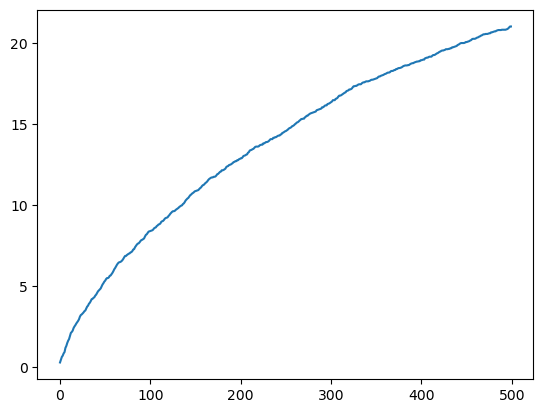

In [23]:
alpha = 1
N = 500
M = 50
avg_regret2 = np.zeros(N)

for m in range(M):
    regret = glmucb(alpha, N)
    avg_regret2 += regret 
avg_regret2 /= M

plt.plot(np.cumsum(avg_regret2))
plt.show()
# The plot used to be more 'curved' at the beginning, just the version I generated for the last run is not that curve, but pretty much should be the same.

In [24]:
# Pretty much similar, just to be safe.

def glmucb(alpha, trials):
    K = 3
    D = 2
    regret = np.zeros(trials)

    beta = [np.ones(D+1) for i in range(K)]
    X = []
    y = []
    # won't change too much
    sample = Products.sample(n = 1, replace=True).iloc[0]
    x = np.array([1, sample['time'], sample['purchases']]) 
    for a in range(K):
        r = sample[f'product{a+1}']
        X.append(x) 
        y.append(r)

    for n in range(trials):
        sample = Products.sample(n = 1, replace=True).iloc[0]
        x = np.array([1, sample['time'], sample['purchases']])

        UCB = []
        for i in range(K):
            d = len(x)
            Ainv = np.linalg.inv(X[i].T@X[i] + np.eye(d))
            Rhat = x @ beta[i]
            Uhat = alpha * np.sqrt(x.T @ Ainv @ x)
            UCB.append(Rhat+Uhat)
        UCB = np.array(UCB)
        
        idx = np.argmax(UCB)
        r = sample[f'product{idx+1}']

        X[idx] = np.vstack((X[idx], x))
        y[idx] = np.append(y[idx], r)
        try:
            beta[idx] = Logit(y[idx],X[idx]).fit(disp=0).params
        except:
            continue

        all_rewards = [sample[f'product{i+1}'] for i in range(K)]
        regret[n] = np.max(all_rewards) - all_rewards[idx]

    return regret

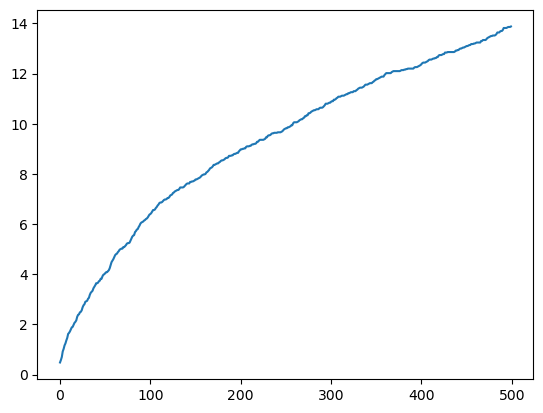

In [25]:
alpha = 1
N = 500
M = 50
avg_regret2 = np.zeros(N)

for m in range(M):
    regret = glmucb(alpha, N)
    avg_regret2 += regret 
avg_regret2 /= M

plt.plot(np.cumsum(avg_regret2))
plt.show()
# The plot used to be more 'curved' at the beginning, just the version I generated for the last run is not that curve, but pretty much should be the same.